# Setup

## Packages

In [ ]:
# data analysis
import pandas as pd
import numpy as np
import scanpy as sc

# cell-cell communication
import liana as li
import cell2cell as c2c

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
from plotnine.options import set_option
from collections import defaultdict

# readability
import warnings

warnings.filterwarnings("ignore")

set_option("limitsize", False)

False

In [ ]:
# NOTE: to use CPU instead of GPU, set use_gpu = False
use_gpu = True

if use_gpu:
    import torch
    import tensorly as tl

    device = "cuda" if torch.cuda.is_available() else "cpu"
    if device == "cuda":
        tl.set_backend("pytorch")
else:
    device = "cpu"

device

'cuda'

## Functions

### Embedding shuffled

In [ ]:
def embedding_shuffled(
    adata,
    basis="X_umap",
    legend_fontsize=12,
    legend_fontoutline=3,
    add_outline=False,
    frameon=False,
    size=None,
    show=False,
    *args,
    **kwargs,
):
    np.random.seed(0)
    random_indices = np.random.permutation(list(range(adata.shape[0])))

    if size is None:
        size = 150000 / adata.n_obs

    sc.pl.embedding(
        adata=adata[random_indices, :],
        basis=basis,
        legend_fontsize=legend_fontsize,
        legend_fontoutline=legend_fontoutline,
        add_outline=add_outline,
        frameon=frameon,
        size=size,
        show=show,
        *args,
        **kwargs,
    )

## Colors

In [ ]:
colors = ["#8c510a", "#bf812d", "#dfc27d", "#c7eae5", "#80cdc1", "#35978f", "#01665e"]
timepoints = ["E18.5", "P1", "P7", "P21", "P60", "P90", "P100"]
timepoint_colors = {timepoints[i]: colors[i] for i in range(len(timepoints))}

In [ ]:
cell_type_colors = {
    "DETC": "#1f78b4",
    "DETC cycling": "#a6cee3",
    "LC": "#e31a1c",
    "LC cycling": "#fb9a99",
    "ILC1": "#33a02c",
    "NK cells": "#b2df8a",
    "Mast cells": "#fdbf6f",
    "squamous epithelial cells": "#ff7f00",
}

## Dataset

In [ ]:
data_path = "/path/to/data/"

detc = sc.read_h5ad(f"{data_path}detc_cleaned.h5ad")
lc = sc.read_h5ad(f"{data_path}lc_cleaned.h5ad")

In [ ]:
adata = sc.concat(
    [detc, lc],
    join='outer',
    merge='same'
)

### Preprocessing

In [ ]:
adata.X = adata.layers["raw_counts"].copy()

sc.pp.normalize_total(
    adata,
    target_sum=1e4,
)

sc.pp.log1p(adata)

adata.layers["log1p_norm"] = adata.X.copy()

sc.pp.highly_variable_genes(
    adata, n_top_genes=2000, flavor="seurat_v3", layer="raw_counts"
)

sc.pp.scale(adata, max_value=10, zero_center=True)

adata.layers["scaled"] = adata.X.copy()

sc.pp.pca(
    adata,
)

sc.external.pp.harmony_integrate(adata, key="batch", adjusted_basis="harmony")

sc.pp.neighbors(
    adata,
    use_rep="harmony",
    n_neighbors=30,
)

sc.tl.umap(
    adata,
)

sc.tl.leiden(adata, resolution=0.8, flavor="igraph", n_iterations=2)

# Ligand-Receptor inference by sample

In [ ]:
adata.obs['cell_type_rough'] = np.where(
    adata.obs['cell_type'].str.contains('DETC'), 'DETC', 'LC'
)

In [ ]:
adata.X = adata.layers['log1p_norm'].copy()

In [ ]:
sample_key = "replicate"
condition_key = "timepoint"
groupby = "cell_type_rough"

In [ ]:
li.mt.rank_aggregate.by_sample(
    adata,
    groupby=groupby,
    resource_name='mouseconsensus',
    sample_key=sample_key,
    use_raw=False,
    verbose=True,
    n_perms=None,
    return_all_lrs=True,
    )

In [ ]:
from liana.method import singlecellsignalr, connectome, cellphonedb, natmi, logfc, cellchat, geometric_mean

In [ ]:
methods = [logfc, geometric_mean, singlecellsignalr, connectome, cellphonedb, natmi, cellchat]
new_rank_aggregate = li.mt.AggregateClass(li.mt.aggregate_meta, methods=methods)

In [ ]:
new_rank_aggregate.by_sample(
   adata,
   sample_key=sample_key,
   groupby=groupby,
   resource_name = 'mouseconsensus',
   use_raw = False,
   verbose = True,
   inplace = True,
   return_all_lrs = True
)

In [ ]:
magnitude_scores = ["lr_means", "expr_prod", "lrscore", "lr_probs"]
liana_corr = adata.uns["liana_res"].copy()[magnitude_scores].corr(method="spearman")

In [ ]:
tensor = li.multi.to_tensor_c2c(
    adata,
    sample_key=sample_key,
    score_key='magnitude_rank',
    how='outer',
    context_order=[
        'spf_e185_1', 'spf_e185_2', 'spf_e185_3',
        'spf_p1_1', 'spf_p1_2', 'spf_p1_3',
        'spf_p7_1', 'spf_p7_2', 'spf_p7_3',
        'spf_p21_1', 'spf_p21_2', 'spf_p21_3',
        'spf_p60_1', 'spf_p60_2', 'spf_p60_3',
        'spf_p90_1', 'spf_p90_2', 'spf_p90_3',
        'spf_p100_1', 'spf_p100_2', 'spf_p100_3',
    ]
)

In [ ]:
context_dict = adata.obs[[sample_key, condition_key]].drop_duplicates()
context_dict = dict(zip(context_dict[sample_key], context_dict[condition_key]))
context_dict = defaultdict(lambda: "Unknown", context_dict)

In [ ]:
tensor_meta = c2c.tensor.generate_tensor_metadata(
    interaction_tensor=tensor,
    metadata_dicts=[context_dict, None, None, None],
    fill_with_order_elements=True,
)

Running Tensor Cell2cell. The first time with rank=None returned 7 as the optimal rank. to keep computation time down, I will set rank 7 as the rank when rerunning this script.

In [ ]:
tensor = c2c.analysis.run_tensor_cell2cell_pipeline(
    tensor,
    tensor_meta,
    copy_tensor=True,
    rank=7,
    tf_optimization="robust",
    random_state=0,
    device=device,
    elbow_metric="error",
    smooth_elbow=False,
    upper_rank=20,
    tf_init="svd",
    tf_svd="numpy_svd",
    cmaps=None,
    sample_col="Element",
    group_col="Category",
    output_fig=True,
)

plt.show()

# Figures

In [ ]:
plt.rcParams.update(
    {
        "font.family": "Arial",
        "font.size": 8,
        "axes.titlesize": "medium",
        "figure.titlesize": "medium",
        "figure.labelsize": "medium",
        "legend.fontsize": 8.0,
        'figure.dpi': 200
    }
)

## Factor barplot

In [ ]:
replicate_to_timepoint = {
    "spf_e185_1": "E18.5",
    "spf_e185_2": "E18.5",
    "spf_e185_3": "E18.5",
    "spf_p21_2": "P21",
    "spf_p21_1": "P21",
    "spf_p21_3": "P21",
    "spf_p1_3": "P1",
    "spf_p1_2": "P1",
    "spf_p1_1": "P1",
    "spf_p90_3": "P90",
    "spf_p90_1": "P90",
    "spf_p90_2": "P90",
    "spf_p7_3": "P7",
    "spf_p7_1": "P7",
    "spf_p7_2": "P7",
    "spf_p60_3": "P60",
    "spf_p60_2": "P60",
    "spf_p60_1": "P60",
    "spf_p100_3": "P100",
    "spf_p100_1": "P100",
    "spf_p100_2": "P100",
}

In [ ]:
replicate_colors = (
    pd.DataFrame.from_dict(
        replicate_to_timepoint, orient="index", columns=["timepoint"]
    )["timepoint"]
    .map(timepoint_colors)
    .to_dict()
)

In [ ]:
factors = tensor.factors

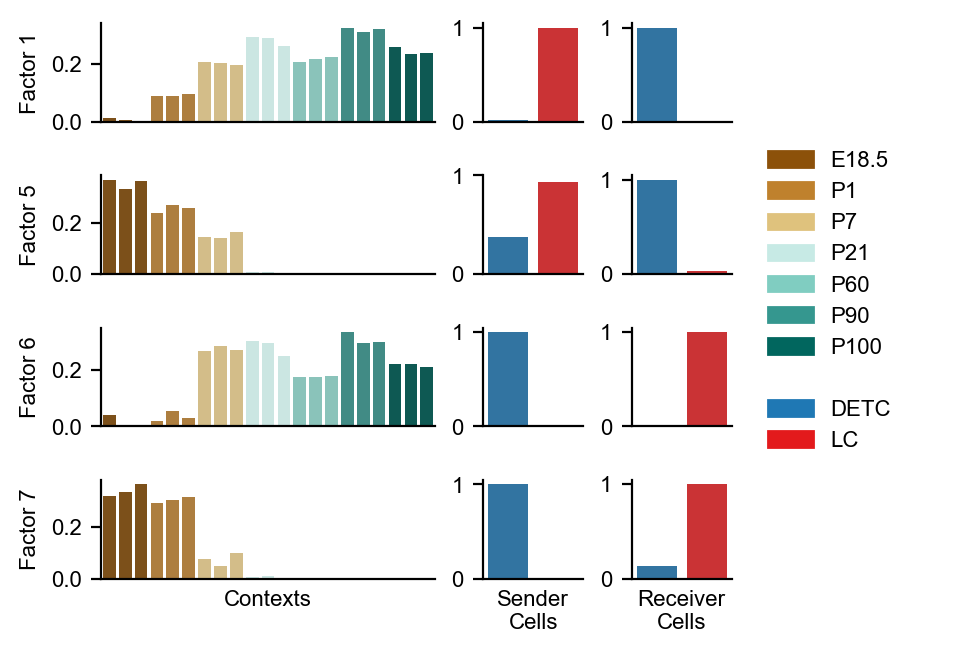

In [ ]:
factors_of_interest = ["Factor 1", "Factor 5", "Factor 6", "Factor 7"]

contexts = tensor.factors["Contexts"].loc[:, factors_of_interest]
lr_pairs = tensor.factors["Ligand-Receptor Pairs"].loc[:, factors_of_interest]
sender_cells = tensor.factors["Sender Cells"].loc[:, factors_of_interest]
receiver_cells = tensor.factors["Receiver Cells"].loc[:, factors_of_interest]

fig = plt.figure(figsize=(120/25.4, 80/25.4), dpi=200, layout="constrained")

gs = gridspec.GridSpec(4, 4, figure=fig, width_ratios=[5, 1.5, 1.5, 3])

for i, context in enumerate(contexts.keys()):
    ax = fig.add_subplot(gs[i, 0])

    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))

    sns.barplot(data=contexts.loc[:, context], palette=replicate_colors)

    ax.set_ylabel(
        context,
        
    )

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ax.set_xticklabels([])
    ax.set_xticks([])

    y_ticklabels_old = ax.get_yticklabels()
    y_ticklabels_new = []

    for label in y_ticklabels_old:
        text = label.get_text()
        new_text = round(float(text), 1)
        y_ticklabels_new.append(new_text)

    ax.set_yticklabels(y_ticklabels_new)

    if context == "Factor 7":
        ax.set_xlabel("Contexts", )

for i, sender_cell in enumerate(sender_cells.keys()):
    ax = fig.add_subplot(gs[i, 1])

    sns.barplot(data=sender_cells.loc[:, sender_cell], palette=cell_type_colors)

    ax.set_ylabel("")
    ax.set_xlabel("")

    ax.set_xticklabels([])
    ax.set_xticks([])

    ax.set_yticks([0,1])

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    if sender_cell == "Factor 7":
        ax.set_xlabel("Sender\nCells", )

for i, receiver_cell in enumerate(receiver_cells.keys()):
    ax = fig.add_subplot(gs[i, 2])

    sns.barplot(data=receiver_cells.loc[:, receiver_cell], palette=cell_type_colors)

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ax.set_ylabel("")
    ax.set_xlabel("")

    ax.set_xticklabels([])
    ax.set_xticks([])

    ax.set_yticks([0,1])

    if receiver_cell == "Factor 7":
        ax.set_xlabel("Receiver\nCells", )

legend_ax = fig.add_subplot(gs[:, 3])

timepoint_patches = [
    mpatches.Patch(color=color, label=label)
    for label, color in timepoint_colors.items()
]

celltype_patches = [
    mpatches.Patch(color=color, label=label)
    for label, color in {
        k: v for k, v in cell_type_colors.items() if k in ["DETC", "LC"]
    }.items()
]

legend_ax.axis("off")

legend_ax.legend(
    handles=(
        timepoint_patches
        + [mpatches.Patch(color="none", label="")]
        + celltype_patches
    ),
    title=None,
    loc="center left",
    frameon=False,
    
)

plt.show()

## Heatmap

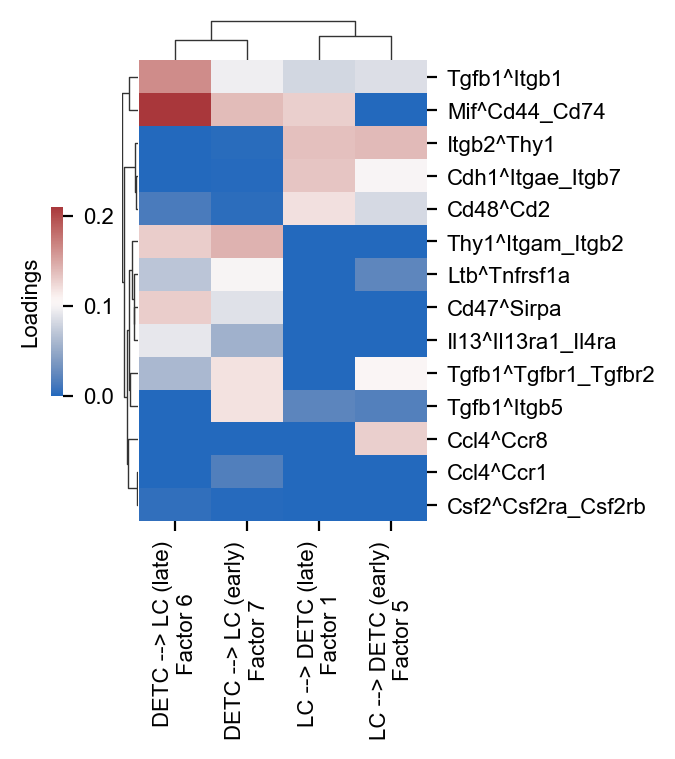

In [ ]:
factors_of_interest = ["Factor 1", "Factor 5", "Factor 6", "Factor 7"]
factor_to_ticklabel = {
    'Factor 1': 'LC --> DETC (late)\nFactor 1',
    'Factor 5': 'LC --> DETC (early)\nFactor 5',
    'Factor 6': 'DETC --> LC (late)\nFactor 6',
    'Factor 7': 'DETC --> LC (early)\nFactor 7',    
}

loadings_of_interest = [
    "Itgb2^Thy1",
    "Cdh1^Itgae_Itgb7",
    "Cd48^Cd2",
    "Ccl4^Ccr8",
    "Ccl4^Ccr1",
    "Tgfb1^Tgfbr1_Tgfbr2",
    "Ltb^Tnfrsf1a",
    "Tgfb1^Itgb5",
    "Thy1^Itgam_Itgb2",
    "Cd47^Sirpa",
    "Tgfb1^Itgb1",
    "Mif^Cd44_Cd74",
    "Il13^Il13ra1_Il4ra",
    "Csf2^Csf2ra_Csf2rb",
]

p1 = c2c.plotting.loading_clustermap(
    loadings=tensor.factors["Ligand-Receptor Pairs"].loc[
        loadings_of_interest,
        factors_of_interest,
    ],
    loading_threshold=0,
    use_zscore=False,
    figsize=(78.264/25.4, 80/25.4),
    row_cluster=True,
    # tick_fontsize=16,
    dendrogram_ratio=0.15,
    method="ward",
    axis_zscore=1,
    heatmap_lw=0,
    cbar_pos=(-0.02, 0.3, 0.02, 0.3),
    cmap="vlag",
)

labels = []

for label in p1.ax_heatmap.get_xticklabels():
    labels.append(factor_to_ticklabel[label.get_text()])

p1.ax_heatmap.set_xticklabels(labels, rotation=90, ha='center')

plt.show()

In [ ]:
# Overall plot sizes, width gets changed if legend is added
plot_width_in = 78.264 / 25.4
plot_height_in = 80 / 25.4
80
# Margin around plot area in inches
margin_left = 0
margin_right = 0
margin_bottom = 0
margin_top = 0

# Legend spacer in inches
legend_width_in = 0
# legend_width_in = 1.27/25.4

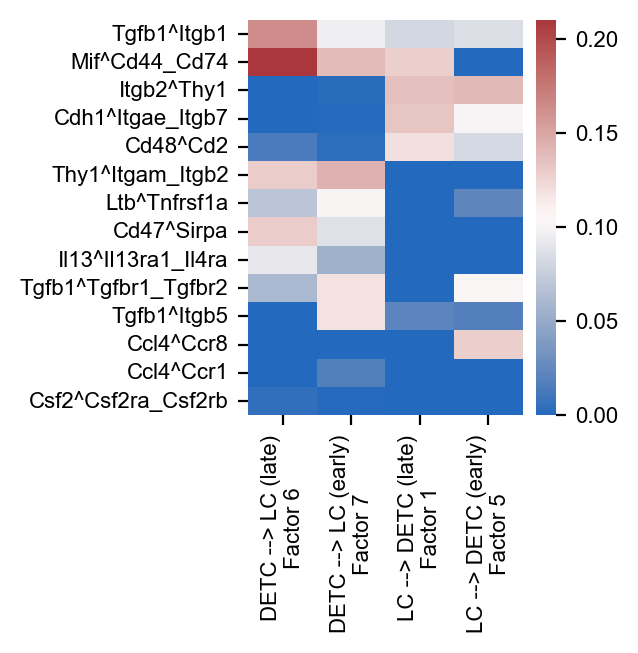

In [ ]:
fig_width = (
    margin_left + plot_width_in + legend_width_in + margin_right
)
fig_height = margin_bottom + plot_height_in + margin_top

fig, axes = plt.subplots(figsize=(fig_width, fig_height), dpi=200, layout="constrained")

sns.heatmap(
    p1.data2d,
    cmap="vlag",
)

labels = []

for label in axes.get_xticklabels():
    labels.append(factor_to_ticklabel[label.get_text()])

axes.set_xticklabels(labels, rotation=90, ha='center')

# Supplementary

## Factor barplot

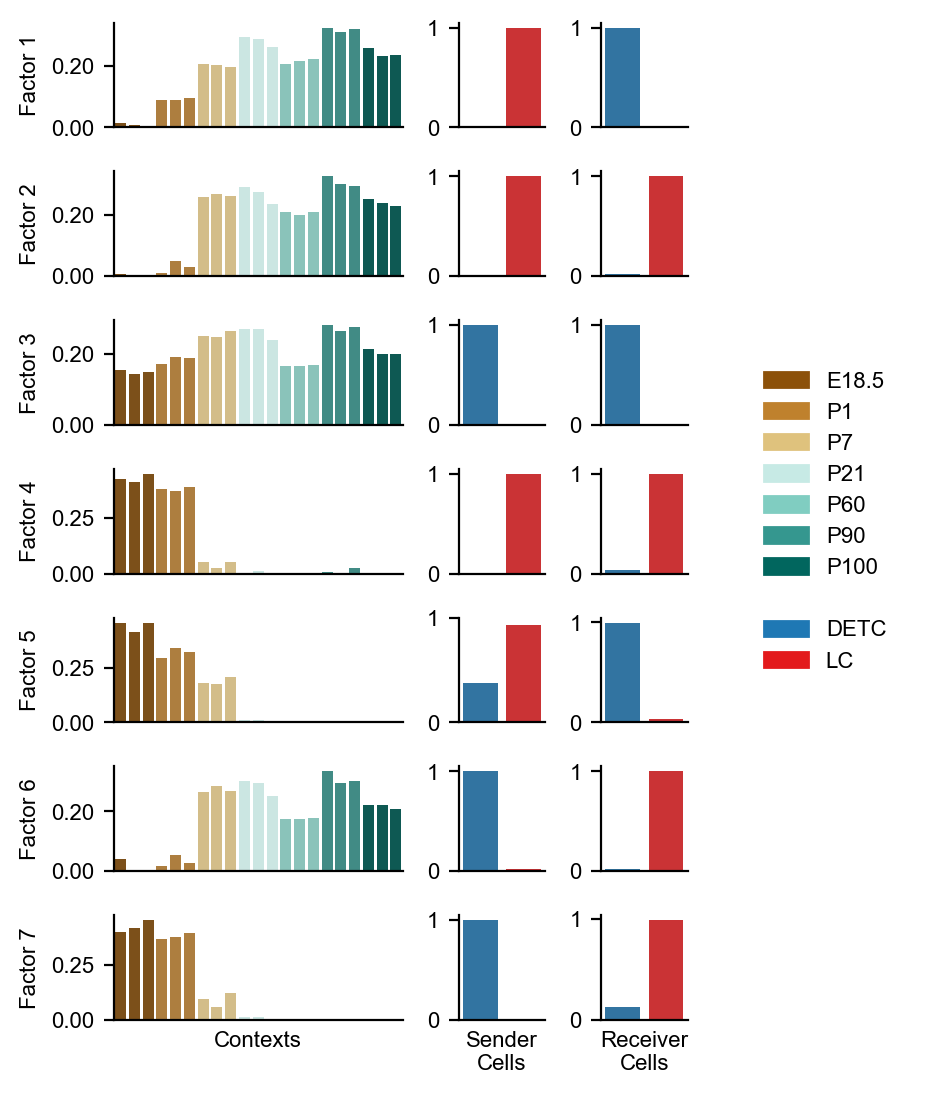

In [ ]:
contexts = factors["Contexts"]
lr_pairs = factors["Ligand-Receptor Pairs"]
sender_cells = factors["Sender Cells"]
receiver_cells = factors["Receiver Cells"]

fig = plt.figure(figsize=(120/25.4, 140/25.4), dpi=200, layout="constrained")

gs = gridspec.GridSpec(7, 4, figure=fig, width_ratios = [5, 1.5, 1.5, 3])

for i, context in enumerate(contexts.keys()):
    ax = fig.add_subplot(gs[i, 0])

    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))

    sns.barplot(data=contexts.loc[:, context], palette=replicate_colors)

    ax.set_ylabel(
        context,
    )

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ax.set_xticklabels([])
    ax.set_xticks([])

    if context == "Factor 7":
        ax.set_xlabel("Contexts")

for i, sender_cell in enumerate(sender_cells.keys()):
    ax = fig.add_subplot(gs[i, 1])

    sns.barplot(data=sender_cells.loc[:, sender_cell], palette=cell_type_colors)

    ax.set_ylabel("")
    ax.set_xlabel("")

    ax.set_xticklabels([])
    ax.set_xticks([])

    ax.set_yticks([0,1])

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    if sender_cell == "Factor 7":
        ax.set_xlabel("Sender\nCells")

for i, receiver_cell in enumerate(receiver_cells.keys()):
    ax = fig.add_subplot(gs[i, 2])

    sns.barplot(data=receiver_cells.loc[:, receiver_cell], palette=cell_type_colors)

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ax.set_ylabel("")
    ax.set_xlabel("")

    ax.set_xticklabels([])
    ax.set_xticks([])

    ax.set_yticks([0,1])

    if receiver_cell == "Factor 7":
        ax.set_xlabel("Receiver\nCells")

legend_ax = fig.add_subplot(gs[:, 3])

timepoint_patches = [
    mpatches.Patch(color=color, label=label)
    for label, color in timepoint_colors.items()
]

celltype_patches = [
    mpatches.Patch(color=color, label=label)
    for label, color in {
        k: v for k, v in cell_type_colors.items() if k in ["DETC", "LC"]
    }.items()
]

legend_ax.axis("off")

legend_ax.legend(
    handles=(
        timepoint_patches
        + [mpatches.Patch(color="none", label="")]
        + celltype_patches
    ),
    title=None,
    loc="center left",
    frameon=False,
)

plt.tight_layout()

plt.show()